In [112]:
# !pip install datasets

In [113]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./data")
print(dataset)
dataset = dataset["train"]

dataset = dataset.shuffle(seed=666).select(range(5000)) # 🤔
dataset = dataset.train_test_split(test_size=0.2, seed=666) # 🤔
test_dataset = dataset["test"]
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5113
    })
})


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

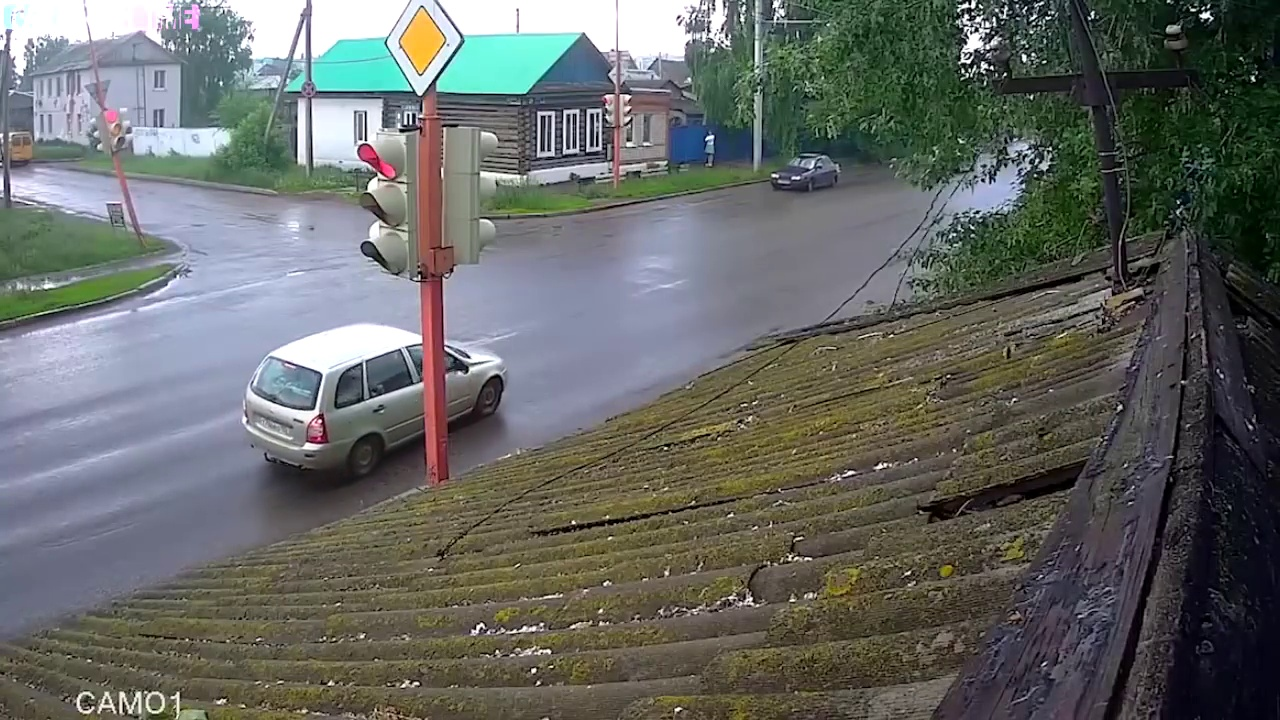

In [114]:
dataset["train"][0]["image"]

In [115]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label

{'0': 'accident', '1': 'non-accident'}

In [116]:
# !pip install torch torchvision torchaudio
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# !pip install transformers

In [117]:
import torch

print(torch.cuda.is_available())

def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

True


In [118]:
from transformers import AutoImageProcessor

checkpoint = "microsoft/resnet-50" # 🤔
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
# checkpoint = "google/vit-base-patch16-224"
# image_processor = ViTImageProcessor.from_pretrained(checkpoint)

In [119]:
from torchvision.transforms import Resize, RandomResizedCrop, ColorJitter, RandomInvert, RandomAdjustSharpness, GaussianBlur, RandomHorizontalFlip, RandomRotation, RandomPerspective, Compose, Normalize, ToTensor, ToPILImage # 🤔
# from copy import deepcopy
# from datasets import concatenate_datasets

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = image_processor.size["shortest_edge"] if "shortest_edge" in image_processor.size else (image_processor.size["height"], image_processor.size["width"])
# _transforms_augment = Compose([
#     RandomResizedCrop(size),
#     ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     RandomInvert(),
#     RandomAdjustSharpness(10),
#     GaussianBlur(kernel_size=(11, 21), sigma=(5, 50)),
#     RandomHorizontalFlip(),
#     RandomRotation(15),
#     RandomPerspective(0.2),
#     ToTensor(),
#     normalize
# ])
_transforms = Compose([
    Resize((size, size)),
    # RandomResizedCrop((size, size)),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    RandomAdjustSharpness(sharpness_factor=0.5, p=0.5),
    # GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
    RandomHorizontalFlip(),
    RandomRotation(5),
    # RandomPerspective(0.2),
    ToTensor(),
    normalize
]) # 🤔

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

# def transforms_augment(examples):
#     examples["image"] = [_transforms_augment(img.convert("RGB")) for img in examples["image"]]
#     return examples

# augmented_dataset = deepcopy(dataset)
# augmented_dataset = augmented_dataset.with_transform(transforms_augment)

# combined_train_dataset = concatenate_datasets([dataset["train"], augmented_dataset["train"]])
# dataset["train"] = combined_train_dataset

dataset = dataset.with_transform(transforms)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

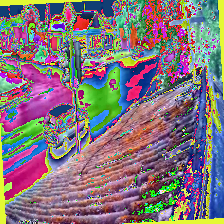

In [120]:
test_img = ToPILImage()
test_img = test_img(dataset["train"][0]["pixel_values"])
test_img

In [121]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()
data_collator

DefaultDataCollator(return_tensors='pt')

In [122]:
# !pip install evaluate
# !pip install scikit-learn

In [123]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [124]:
# !pip install accelerate
# !pip install optuna

In [125]:
import os
import shutil
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

def clear_output_dir(output_dir):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
        print(f"Cleared the directory: {output_dir}")

clear_output_dir("my_image_model")
clear_output_dir("my_final_image_model")

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
    
training_args = TrainingArguments(
    output_dir="my_image_model", # 🤔
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch", # 🤔
    learning_rate=3e-4, # 🤔 1e-3 // 3e-4
    per_device_train_batch_size=32, # 🤔 32
    gradient_accumulation_steps=4, # 🤔 4
    per_device_eval_batch_size=32, # 🤔 32
    num_train_epochs=20.0, # 🤔 20.0
    warmup_ratio=0.1, # 🤔 0.1
    logging_steps=500, # 🤔 500
    load_best_model_at_end=True, # 🤔
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("my_final_image_model") # 🤔

Cleared the directory: my_image_model
Cleared the directory: my_final_image_model


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  5%|▌         | 31/620 [01:27<23:51,  2.43s/it]

{'eval_loss': 0.6441538333892822, 'eval_accuracy': 0.777, 'eval_runtime': 12.0786, 'eval_samples_per_second': 82.791, 'eval_steps_per_second': 2.649, 'epoch': 0.99}


 10%|█         | 62/620 [02:59<23:40,  2.55s/it]

{'eval_loss': 0.3380008041858673, 'eval_accuracy': 0.873, 'eval_runtime': 12.8365, 'eval_samples_per_second': 77.903, 'eval_steps_per_second': 2.493, 'epoch': 1.98}


 15%|█▌        | 93/620 [04:37<23:03,  2.63s/it]

{'eval_loss': 0.1676199585199356, 'eval_accuracy': 0.937, 'eval_runtime': 13.1087, 'eval_samples_per_second': 76.285, 'eval_steps_per_second': 2.441, 'epoch': 2.98}


 20%|██        | 125/620 [06:15<21:53,  2.65s/it]

{'eval_loss': 0.1345163732767105, 'eval_accuracy': 0.944, 'eval_runtime': 13.3375, 'eval_samples_per_second': 74.977, 'eval_steps_per_second': 2.399, 'epoch': 4.0}


 25%|██▌       | 156/620 [07:56<21:14,  2.75s/it]

{'eval_loss': 0.12681180238723755, 'eval_accuracy': 0.954, 'eval_runtime': 13.9748, 'eval_samples_per_second': 71.557, 'eval_steps_per_second': 2.29, 'epoch': 4.99}


 30%|███       | 187/620 [09:37<19:57,  2.77s/it]

{'eval_loss': 0.13217772543430328, 'eval_accuracy': 0.953, 'eval_runtime': 13.9184, 'eval_samples_per_second': 71.847, 'eval_steps_per_second': 2.299, 'epoch': 5.98}


 35%|███▌      | 218/620 [11:18<18:43,  2.80s/it]

{'eval_loss': 0.10017966479063034, 'eval_accuracy': 0.966, 'eval_runtime': 13.8326, 'eval_samples_per_second': 72.293, 'eval_steps_per_second': 2.313, 'epoch': 6.98}


 40%|████      | 250/620 [13:01<16:59,  2.75s/it]

{'eval_loss': 0.11313602328300476, 'eval_accuracy': 0.956, 'eval_runtime': 14.1699, 'eval_samples_per_second': 70.572, 'eval_steps_per_second': 2.258, 'epoch': 8.0}


 45%|████▌     | 281/620 [14:44<15:49,  2.80s/it]

{'eval_loss': 0.13376092910766602, 'eval_accuracy': 0.955, 'eval_runtime': 13.9009, 'eval_samples_per_second': 71.938, 'eval_steps_per_second': 2.302, 'epoch': 8.99}


 50%|█████     | 312/620 [16:26<14:17,  2.78s/it]

{'eval_loss': 0.12152106314897537, 'eval_accuracy': 0.959, 'eval_runtime': 14.1662, 'eval_samples_per_second': 70.591, 'eval_steps_per_second': 2.259, 'epoch': 9.98}


 55%|█████▌    | 343/620 [18:10<13:09,  2.85s/it]

{'eval_loss': 0.10852067172527313, 'eval_accuracy': 0.967, 'eval_runtime': 14.7014, 'eval_samples_per_second': 68.021, 'eval_steps_per_second': 2.177, 'epoch': 10.98}


 60%|██████    | 375/620 [19:53<11:05,  2.72s/it]

{'eval_loss': 0.11620885878801346, 'eval_accuracy': 0.967, 'eval_runtime': 14.1141, 'eval_samples_per_second': 70.851, 'eval_steps_per_second': 2.267, 'epoch': 12.0}


 65%|██████▌   | 406/620 [21:35<09:51,  2.76s/it]

{'eval_loss': 0.10130664706230164, 'eval_accuracy': 0.967, 'eval_runtime': 14.0527, 'eval_samples_per_second': 71.161, 'eval_steps_per_second': 2.277, 'epoch': 12.99}


 70%|███████   | 437/620 [23:19<08:37,  2.83s/it]

{'eval_loss': 0.10275973379611969, 'eval_accuracy': 0.964, 'eval_runtime': 16.004, 'eval_samples_per_second': 62.484, 'eval_steps_per_second': 1.999, 'epoch': 13.98}


 75%|███████▌  | 468/620 [25:04<07:01,  2.78s/it]

{'eval_loss': 0.09421458095312119, 'eval_accuracy': 0.967, 'eval_runtime': 13.9418, 'eval_samples_per_second': 71.727, 'eval_steps_per_second': 2.295, 'epoch': 14.98}


 81%|████████  | 500/620 [26:32<05:22,  2.69s/it]

{'loss': 0.1298, 'grad_norm': 0.9465112686157227, 'learning_rate': 6.451612903225805e-05, 'epoch': 16.0}



 81%|████████  | 500/620 [26:46<05:22,  2.69s/it]

{'eval_loss': 0.0995042696595192, 'eval_accuracy': 0.966, 'eval_runtime': 14.0013, 'eval_samples_per_second': 71.422, 'eval_steps_per_second': 2.285, 'epoch': 16.0}


 86%|████████▌ | 531/620 [28:27<04:08,  2.79s/it]

{'eval_loss': 0.10333042591810226, 'eval_accuracy': 0.963, 'eval_runtime': 14.0821, 'eval_samples_per_second': 71.012, 'eval_steps_per_second': 2.272, 'epoch': 16.99}


 91%|█████████ | 562/620 [30:09<02:41,  2.78s/it]

{'eval_loss': 0.1104336827993393, 'eval_accuracy': 0.962, 'eval_runtime': 14.0585, 'eval_samples_per_second': 71.131, 'eval_steps_per_second': 2.276, 'epoch': 17.98}


 96%|█████████▌| 593/620 [31:59<01:28,  3.27s/it]

{'eval_loss': 0.0898422971367836, 'eval_accuracy': 0.972, 'eval_runtime': 15.0465, 'eval_samples_per_second': 66.461, 'eval_steps_per_second': 2.127, 'epoch': 18.98}


100%|██████████| 620/620 [33:28<00:00,  2.73s/it]

{'eval_loss': 0.09931819140911102, 'eval_accuracy': 0.967, 'eval_runtime': 14.366, 'eval_samples_per_second': 69.609, 'eval_steps_per_second': 2.227, 'epoch': 19.84}


100%|██████████| 620/620 [33:28<00:00,  3.24s/it]

{'train_runtime': 2008.8257, 'train_samples_per_second': 39.824, 'train_steps_per_second': 0.309, 'train_loss': 0.10827962237019692, 'epoch': 19.84}


In [126]:
results = trainer.evaluate()
print(results)

100%|██████████| 32/32 [00:13<00:00,  2.38it/s]

{'eval_loss': 0.10286220908164978, 'eval_accuracy': 0.967, 'eval_runtime': 14.2627, 'eval_samples_per_second': 70.113, 'eval_steps_per_second': 2.244, 'epoch': 19.84}


non-accident


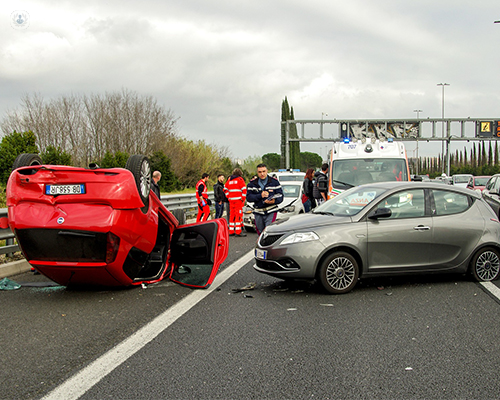

In [140]:
from PIL import Image

image = test_dataset[0] # 🤔
print(id2label[str(image['label'])])
image = image['image']
image = Image.open("outsource_data/test1.jpg")
image

In [141]:
from transformers import pipeline

classifier = pipeline("image-classification", model="./my_final_image_model", device=torch.device("cuda"))
print(classifier(image)[0]["label"])
classifier(image)

accident


[{'label': 'accident', 'score': 0.8209945559501648},
 {'label': 'non-accident', 'score': 0.18618133664131165}]

In [129]:
# Zero-Shot

# classifier = pipeline(model="openai/clip-vit-large-patch14", task="zero-shot-image-classification")
# classifier(
#     image,
#     candidate_labels=["accident", "non-accident"],
# )